# CV project

## import libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from skimage.metrics import structural_similarity as ssim
from tensorflow import keras
from IPython.display import SVG
from tensorflow.keras.utils import plot_model

## functions

In [2]:
def predict(model, images):
  y_pred = model.predict(images)
  number = ""
  for i in range(len(images)):
    sample_lbl = np.argmax(y_pred[i])
    number += str(sample_lbl)
  return number
def imshow(im):
    width, height, *channels = im.shape
    if channels:
        # By default, OpenCV tends to work with images in the BGR format.
        # This is due to some outdated practices, but it has been left in the library.
        # We can iterate the channels in reverse order to get an RGB image.
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im, cmap='gray')
    plt.axis('off')
    plt.show()

def remove_shadow(image: np.ndarray, blockSize):
  mean = cv2.blur(image, (blockSize, blockSize))
  no_shadow = image / mean
  return cv2.normalize(no_shadow, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)


def reorder(vertices):
    # OpenCV *prefers* if we use `np.float32`.
    reordered = np.zeros_like(vertices, dtype=np.float32)
    add = vertices.sum(1)
    reordered[0] = vertices[np.argmin(add)]
    reordered[2] = vertices[np.argmax(add)]
    diff = np.diff(vertices, axis=1).squeeze()
    reordered[1] = vertices[np.argmin(diff)]
    reordered[3] = vertices[np.argmax(diff)]
    # reordered = vertices[diff.argsort()]
    print(add, diff)
    return reordered

def transform(image,cornerpoints):
  cornerpoints = reorder(cornerpoints)
  print(cornerpoints)
  # Assign the corner points to variables
  (w1, w2, h1, h2) = cornerpoints

  # Calculate the width and height of the image
  FirstWidth = np.sqrt((((w2[1] - w1[1]) ** 2) + (w2[0] - w1[0]) ** 2))
  SecondWidth = np.sqrt((((h1[1] - h2[1]) ** 2) + (h1[0] - h2[0]) ** 2))
  FirstHeight = np.sqrt((((w2[1] - h1[1]) ** 2) + (w2[0] - h1[0]) ** 2))
  SecondHeight = np.sqrt((((w1[1] - h2[1]) ** 2) + (w1[0] - h2[0]) ** 2))

  # Determine the best width and height
  BestWidth = max(int(FirstWidth), int(SecondWidth))
  BestHeight = max(int(FirstHeight), int(SecondHeight))
  # BestWidth, BestHeight = (640,400)

  # Define the destination points for the perspective transform
  a = [0, 0]
  b = [BestWidth - 1, 0]
  c = [BestWidth - 1, BestHeight - 1]
  d = [0, BestHeight - 1]
  dest = np.array([ a, b, c, d], dtype = "float32")

  # Get the perspective transform matrix
  M = cv2.getPerspectiveTransform(cornerpoints, dest)

  # Apply the perspective transform to the image
  finalimg = cv2.warpPerspective(image, M, (BestWidth, BestHeight))

  # # Display the cropped image
  # plt.imshow(finalimg )
  return  finalimg

def project(image):
  img1=image.copy()
  grayimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype('uint8')
  bilateralimg = cv2.bilateralFilter(grayimg, 10, 10, 10)
  th2 = cv2.adaptiveThreshold(bilateralimg,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,5,2)
  edgesimg = cv2.Canny(th2, 50, 60, None, 3)
  kernel_dilate = np.ones((5, 5), np.uint8)
  img_dilate = cv2.dilate(edgesimg , kernel_dilate, iterations=1)

  # Find contours in the image
  contours, hierarchy = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  max_area = 0
  max_contour = []
  for c in contours:
      # Find the contour perimeter
      perimeter = cv2.arcLength(c, True)
      # Approximate the paper's contour with approxPolyDP function
      approx = cv2.approxPolyDP(c, 0.02 * perimeter, True)
      area = cv2.contourArea(c)
      cornerpoints=[]
      # If the contour has four sides, show it
      if len(approx) ==4 and area>max_area:
          max_area = area
          max_contour = approx
      # print(len(max_contour))
  if len(max_contour)>0:
        cv2.drawContours(img1, [max_contour], -1, (0, 255, 0), 2)
        for point in max_contour:
            x, y = point.ravel()
            cornerpoints.append([x,y])
  cornerpoints=np.array(cornerpoints, dtype = 'object')
  cornerpoints=np.float32(cornerpoints)
  print(cornerpoints)
  plt.scatter([x for x, y in cornerpoints], [y for x, y in cornerpoints])
  imshow(img1)
  img2=image.copy()
  finalimg=transform(img2,cornerpoints)
  return finalimg

## Part a - Pretrain code

(960, 1280, 3)


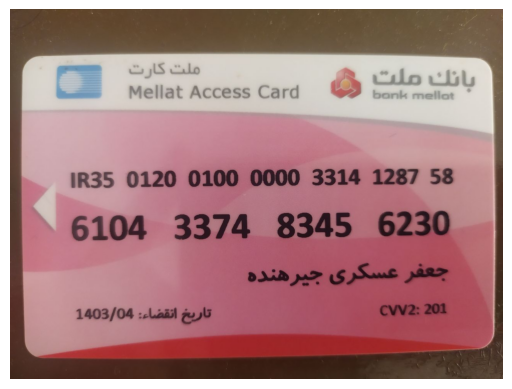

In [47]:
# your code here #
# your code here #
# filename = '3.jpg'
filename = '2.jpg'
image = cv2.imread(filename)
print(image.shape)
imshow(image)

[[  30.  145.]
 [  61.  905.]
 [1279.  910.]
 [1231.  123.]]


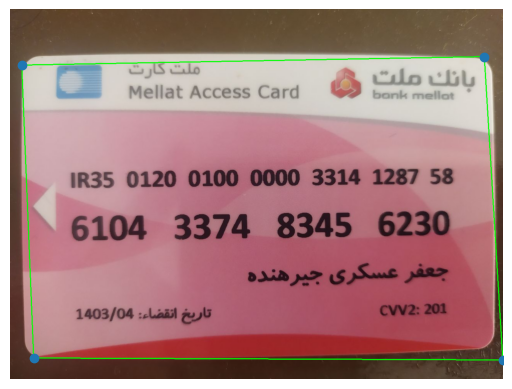

[ 175.  966. 2189. 1354.] [  115.   844.  -369. -1108.]
[[  30.  145.]
 [1231.  123.]
 [1279.  910.]
 [  61.  905.]]
(788, 1218, 3)


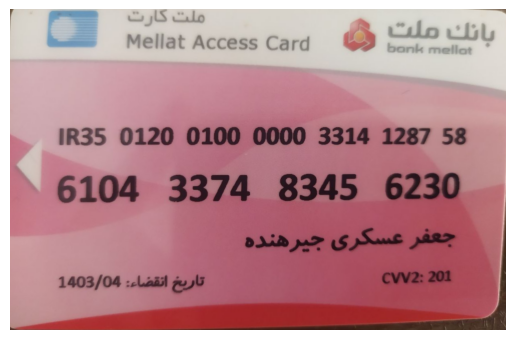

In [48]:
finalimg=project(image)
# vertices = np.array([
#     [150, 250],
#     [150, 800],
#     [1000, 750],
#     [900, 300]
# ])
# finalimg = transform(image, vertices)
print(finalimg.shape)
imshow(finalimg)

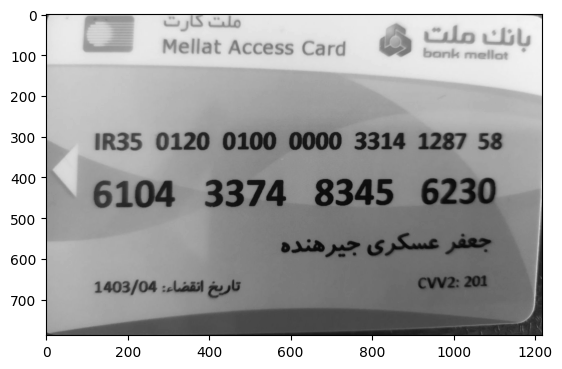

In [49]:
finalgray=cv2.cvtColor(finalimg , cv2.COLOR_BGR2GRAY)
plt.imshow(finalgray,cmap='gray')

## pat b - predict images

### template matching

In [50]:
finalgrayresize=cv2.resize(finalgray, (640,400))
id_template=cv2.imread('template.jpg')
id_templategray=cv2.cvtColor(id_template , cv2.COLOR_BGR2GRAY)
id_templategray = cv2.resize(id_templategray, (60, 60))

h,w=id_templategray.shape

In [51]:
def Cardrecognition(finalgrayresize,id_templategray):
  wb,hb=finalgrayresize.shape
  test_img=finalgrayresize.copy()
  typecard='Bank card'
  x, y = 70, 70
  # Perform template matching
  resized_template = cv2.resize(id_templategray, (x,y))
  # resized_template = cv2.adaptiveThreshold(resized_template, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 7)
  result = cv2.matchTemplate(finalgrayresize, resized_template, cv2.TM_CCOEFF_NORMED)
  # Set a threshold for the result
  threshold = 0.7
  # Find the location of the template in the image where the result is greater than the threshold
  loc = np.where(result >= threshold)
  # Draw a rectangle around the template if found
  if loc[0].size > 0 and loc[1].size > 0:
    # print(loc)
    top_left = (loc[1][0], loc[0][0])
    bottom_right = (loc[1][0] + resized_template.shape[1], loc[0][0] + resized_template.shape[0])
    cv2.rectangle(test_img, top_left, bottom_right, (0, 0, 255), 2)
    typecard='National card'
    print(x,y)
  print(typecard)
  # plt.imshow(test_img,cmap='gray')
  plt.imshow(result,cmap='gray')
  plt.colorbar()
  plt.show()
  return typecard


Bank card


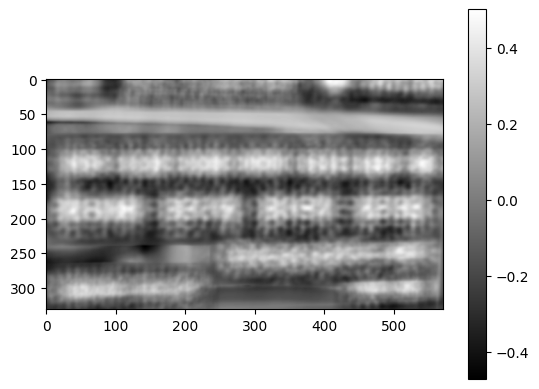

In [52]:
typecard=Cardrecognition(finalgrayresize,id_templategray)

<h3>part 3</h3>

In [53]:
def improveimgcrop(imagecrop):
  # Improve image quality
  finalimg1=imagecrop.copy()
  # Create a sharpening kernel
  kernel_sharpening = np.array([[-1,-1,-1],[-1, 9,-1],[-1,-1,-1]])

  # Apply the sharpening kernel to the image
  sharpeimg = cv2.filter2D(finalimg1, -1, kernel_sharpening)

  # Convert the image to the HSV color space
  huesaturationvalue = cv2.cvtColor(sharpeimg, cv2.COLOR_BGR2HSV)

  # Split the image into its hue, saturation, and value components
  hue, saturation, value = cv2.split(huesaturationvalue)

  # Set a limit for the value and saturation channels
  lim = 255 - 40

  # Increase the brightness of the pixels with a low value channel
  value[value > lim] = 255
  value[value <= lim] += 30

  # Increase the saturation of the pixels with a low saturation channel
  saturation[saturation > lim] = 255
  saturation[saturation <= lim] += 35

  # Combine the hue, saturation, and value channels back into an image
  im3 = cv2.merge((hue, saturation, value))

  # Convert the image back to the BGR color space
  improveimg = cv2.cvtColor(im3, cv2.COLOR_HSV2BGR)
  return improveimg

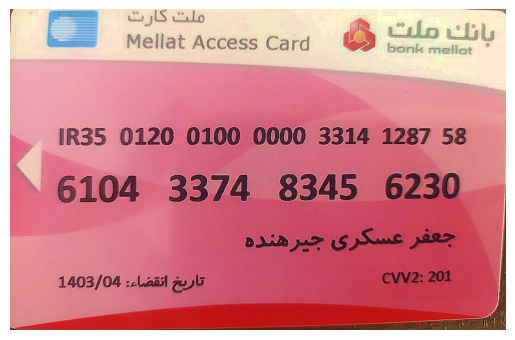

In [54]:
test = improveimgcrop(finalimg)
imshow(test)

In [55]:
def find_digits(image, card_type):
    resized = cv2.resize(image, (640, 400))
    filter_size = (11, 75)
    if card_type == 'National card':
        filter_size = (11, 35)
    eroded = cv2.erode(resized, np.ones(filter_size))
    opened = cv2.dilate(eroded, np.ones(filter_size))
    opened_gray = cv2.cvtColor(opened, cv2.COLOR_RGB2GRAY)
    threshold = cv2.adaptiveThreshold(opened_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 301, 60)

    contours, hierarchy = cv2.findContours(threshold,
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    max_width = 0
    max_x = 0
    max_y = 0
    max_h = 0

    image_copy = resized.copy()
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if (x < 20 or x > image.shape[1] - 20) and (y < 20 or y > image.shape[0] - 20):
            continue
        x-=10
        y-=10
        w+=10
        h+=10
        # Draw the rectangle on the image
        is_candidate = y+h > (image.shape[0] / 4)
        if card_type == 'National card':
            is_candidate = (x+w > image.shape[0] / 2) and (y+h < image.shape[0] / 2)
        if is_candidate:
            cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
            if w > max_width:
                if card_type == 'National card' and (y > max_y) and w - max_width < 20:
                    continue
                max_width = w
                max_x = x
                max_y = y
                max_h = h

    imshow(opened)
    imshow(threshold)
    imshow(image_copy)
    crop_image = resized[max_y:max_y+max_h+5, max_x:max_x+max_width+5].copy()
    return crop_image

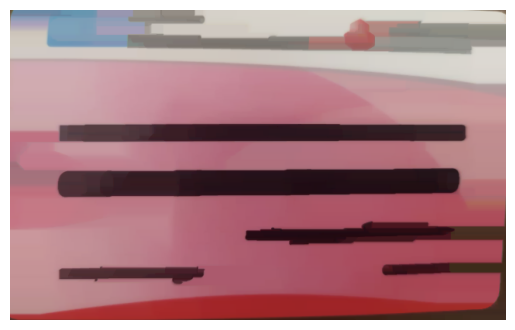

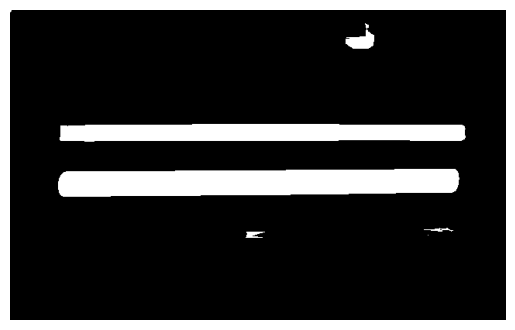

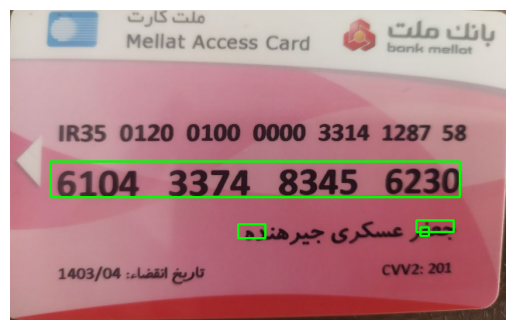

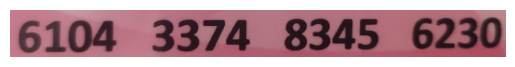

In [56]:
boxnum = find_digits(finalimg, typecard)
imshow(boxnum)

647


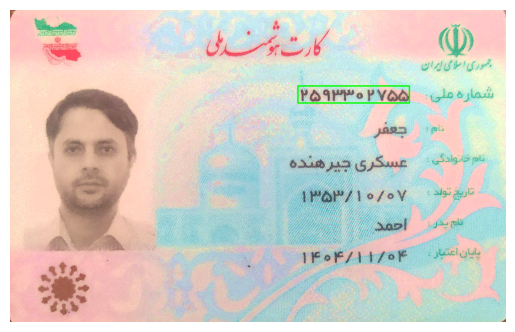

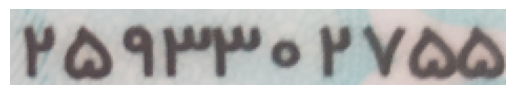

(36, 236, 3)


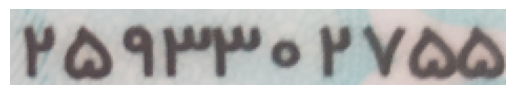

True

In [25]:
def improveimgcrop(imagecrop):
  # Improve image quality
  finalimg1=imagecrop.copy()
  # Create a sharpening kernel
  kernel_sharpening = np.array([[-1,-1,-1],[-1, 9,-1],[-1,-1,-1]])

  # Apply the sharpening kernel to the image
  sharpeimg = cv2.filter2D(finalimg1, -1, kernel_sharpening)

  # Convert the image to the HSV color space
  huesaturationvalue = cv2.cvtColor(sharpeimg, cv2.COLOR_BGR2HSV)

  # Split the image into its hue, saturation, and value components
  hue, saturation, value = cv2.split(huesaturationvalue)

  # Set a limit for the value and saturation channels
  lim = 255 - 40

  # Increase the brightness of the pixels with a low value channel
  value[value > lim] = 255
  value[value <= lim] += 30

  # Increase the saturation of the pixels with a low saturation channel
  saturation[saturation > lim] = 255
  saturation[saturation <= lim] += 35

  # Combine the hue, saturation, and value channels back into an image
  im3 = cv2.merge((hue, saturation, value))

  # Convert the image back to the BGR color space
  improveimg = cv2.cvtColor(im3, cv2.COLOR_HSV2BGR)
  return improveimg

def detectboxnumbers(typecard,imagecrop):
  if typecard=='National card':
    improveimg=improveimgcrop(imagecrop)
    improveimg=cv2.resize(improveimg,(1050,661))
    aa=improveimg.copy()
    ss=imagecrop.copy()
    ss=cv2.resize(ss,(1050,661))
    finalimggray=cv2.cvtColor(improveimg,cv2.COLOR_BGR2GRAY)

    # Threshold the image
    ret, thresh6 = cv2.threshold(finalimggray, 100, 255, cv2.THRESH_BINARY)

    # Apply the Sobel filter
    sobelx = cv2.Sobel(thresh6, cv2.CV_8U, 1, 0, ksize=3)
    sobelx=np.abs(sobelx)

    # # Apply thresholding to convert the image to black and white
    # thresh_value = 100
    # ret, thresh = cv2.threshold(sobelx, thresh_value, 255, cv2.THRESH_BINARY)


    # Define the vertical structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 4))

    # Apply the morphological opening operation
    opened = cv2.morphologyEx(sobelx, cv2.MORPH_OPEN, kernel)

    # Define the horizontal structuring element
    kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (55, 8))

    # Apply the morphological closing operation
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel1)
    contours, hierarchy = cv2.findContours(closed,
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rectangles = []
    # Draw bounding rectangles for each contour
    for cnt in contours:
        # Calculate bounding rectangle for the contour
        x, y, w, h = cv2.boundingRect(cnt)
        # Draw the rectangle on the image
        x-=10
        y-=10
        w+=10
        h+=10
        if x>aa.shape[1]/2 and y<aa.shape[0]/2 and x>=0 and y>=0:
            # cv2.rectangle(aa, (x-10, y-10), (x + w, y + h), (0, 255, 0), 2)
            rectangles.append((x, y, w, h))

    # Find the rectangle with the largest width
    max_width_rectangle = max(rectangles, key=lambda x: x[2])
    # Sort the rectangles by y-coordinate
    rectangles_sorted_by_y = sorted(rectangles, key=lambda x: x[1])

    print(rectangles_sorted_by_y[1][0])

    for i in range(len(rectangles_sorted_by_y)):
        if rectangles_sorted_by_y[i][2]>0.8*max_width_rectangle[2]:
            x= rectangles_sorted_by_y[i][0]
            y=rectangles_sorted_by_y[i][1]
            w=rectangles_sorted_by_y[i][2]
            h=rectangles_sorted_by_y[i][3]
            cropped_image = ss[y:y+h, x:x+w]
            cv2.rectangle(aa, (x, y), (x + w, y + h), (0, 255, 0), 2)
            break
    imshow(aa)
    imshow(cropped_image)
    return cropped_image
  else:
    improveimg=improveimgcrop(imagecrop)
    improveimg=cv2.resize(improveimg,(1218,788))
    aa=improveimg.copy()
    ss=imagecrop.copy()
    ss=cv2.resize(ss,(1218,788))
    finalimggray=cv2.cvtColor(improveimg,cv2.COLOR_BGR2GRAY)


    # Apply the Sobel filter
    sobelx = cv2.Sobel(finalimggray, cv2.CV_8U, 1, 0, ksize=3)
    sobelx=np.abs(sobelx)

    # Apply thresholding to convert the image to black and white
    thresh_value = 100
    ret, thresh = cv2.threshold(sobelx, thresh_value, 255, cv2.THRESH_BINARY)


    # Define the vertical structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 4))

    # Apply the morphological opening operation
    opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # Define the horizontal structuring element
    kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (90, 10))

    # Apply the morphological closing operation
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel1)

    imshow(closed )

    contours, hierarchy = cv2.findContours(closed ,
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    max_width = 0
    max_x = 0
    max_y = 0
    max_h = 0

    # Draw bounding rectangles for each contour
    for cnt in contours:
        # Calculate bounding rectangle for the contour
        x, y, w, h = cv2.boundingRect(cnt)
        x-=10
        y-=10
        w+=10
        h+=10
        # Draw the rectangle on the image
        if y+h>(1/2)*aa.shape[0]:
            cv2.rectangle(aa, (x, y), (x + w, y + h), (0, 255, 0), 2)
            if w > max_width:
                max_width = w
                max_x = x
                max_y = y
                max_h = h
                cv2.rectangle(aa, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Crop the image using the coordinates of the bounding rectangle with maximum width
    crop_img = ss[max_y:max_y+max_h, max_x:max_x+max_width]
    imshow(aa)
    return crop_img
boxnum=detectboxnumbers(typecard,finalimg)
print(boxnum.shape)
imshow(boxnum)
cv2.imwrite('test.jpg',boxnum)

In [57]:
def segmentate(image, card_type, show=False):
    image_copy = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
    gray = cv2.medianBlur(gray, 3)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 8)
    segments = []
    visited = np.zeros((400, 640))
    queue = []
    black = np.where(binary == 0)
    size_threshold = (10, 20)
    if card_type == 'National card':
        size_threshold = (1, 5)
    for x, y in zip(*black):
        # print(x, y)
        if visited[x, y]:
            continue
        left, right = y, y
        top, bottom = x, x
        visited[x, y] = 1
        if y > 0:
            queue.append((x, y-1))
        if y < width-1:
            queue.append((x, y+1))
        if x > 0:
            queue.append((x-1, y))
        if x < height-1:
            queue.append((x+1, y))
        while len(queue) > 0:
            i, j = queue.pop(0)
            if binary[i, j] != 0 or visited[i, j]:
                continue
            visited[i, j] = 1
            left = min(left, j)
            right = max(right, j)
            top = min(top, i)
            bottom = max(bottom, i)
            if j > 0:
                queue.append((i, j-1))
            if j < width-1:
                queue.append((i, j+1))
            if i > 0:
                queue.append((i-1, j))
            if i < height-1:
                queue.append((i+1, j))
        if (right - left >= size_threshold[0]) and (bottom - top >= size_threshold[1]):
            top_left = (max(0,left-3), max(0,top-5))
            bottom_right = (min(width-1,right+3), min(height-1,bottom+5))
            cv2.rectangle(image_copy, top_left, bottom_right, (0, 0, 255), 2)
            segment = image[top_left[1]:bottom_right[1]+1, top_left[0]:bottom_right[0]+1].copy()
            segments.append((top_left[0], segment))
    segments = sorted(segments, key=lambda segment: segment[0])
    segments = list(map(lambda segment: segment[1], segments))
    if show:
        imshow(image_copy)
    return segments

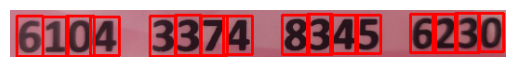

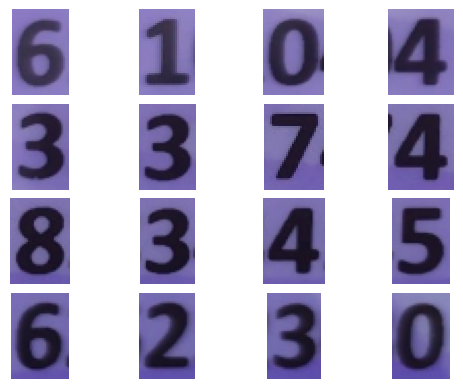

In [61]:
digits = segmentate(boxnum, typecard, True)

fig, axes = plt.subplots(nrows=4, ncols=4)
axes = axes.flatten()

for i, img in enumerate(digits):
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

### create your model

In [28]:
# load dataset
(x_train_en, y_train_en), (x_valid_en, y_valid_en) = keras.datasets.mnist.load_data()
x_train_en = 255 - x_train_en
x_valid_en = 255 - x_valid_en

11490434/11490434 [==============================] - 2s 0us/step


In [29]:
def preprocess_dataset(x_train, y_train, x_valid, y_valid):
    num_classes = 10
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)

    x_train = x_train.astype(float) / 255
    x_valid = x_valid.astype(float) / 255

    x_train = np.expand_dims(x_train, axis=-1)
    x_valid = np.expand_dims(x_valid, axis=-1)

    return (x_train, y_train), (x_valid, y_valid)

In [30]:
(x_train_en, y_train_en), (x_valid_en, y_valid_en) = preprocess_dataset(x_train_en, y_train_en, x_valid_en, y_valid_en)
print(x_train_en.shape, y_train_en.shape)
print(x_valid_en.shape, y_valid_en.shape)

(60000, 28, 28, 1) (60000, 10)
(10000, 28, 28, 1) (10000, 10)


In [31]:
def create_lenet_model(input_shape, num_classes=10):

    model = keras.Sequential()
    model.add(keras.layers.Input(shape=input_shape))

    model.add(keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu'))
    model.add(keras.layers.MaxPooling2D())

    model.add(keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
    model.add(keras.layers.MaxPooling2D())

    model.add(keras.layers.Flatten(input_shape=x_train_en[0].shape))
    model.add(keras.layers.Dense(units=120, activation='relu'))
    model.add(keras.layers.Dense(units=84, activation='relu'))

    model.add(keras.layers.Dense(units=num_classes, activation='softmax'))

    return model

In [32]:
digit_en_model = create_lenet_model(x_train_en[0].shape)

digit_en_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)               3

In [33]:
# compile model
digit_en_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# train model
history_en = digit_en_model.fit(x_train_en, y_train_en, batch_size=100, epochs=10, validation_data=(x_valid_en, y_valid_en), shuffle=True)

Epoch 1/10
600/600 [==============================] - 14s 5ms/step - loss: 0.3513 - accuracy: 0.8953 - val_loss: 0.0875 - val_accuracy: 0.9739
Epoch 2/10
600/600 [==============================] - 4s 6ms/step - loss: 0.0887 - accuracy: 0.9728 - val_loss: 0.0643 - val_accuracy: 0.9805
Epoch 3/10
600/600 [==============================] - 3s 5ms/step - loss: 0.0626 - accuracy: 0.9808 - val_loss: 0.0509 - val_accuracy: 0.9843
Epoch 4/10
600/600 [==============================] - 3s 4ms/step - loss: 0.0483 - accuracy: 0.9847 - val_loss: 0.0401 - val_accuracy: 0.9875
Epoch 5/10
600/600 [==============================] - 3s 5ms/step - loss: 0.0405 - accuracy: 0.9873 - val_loss: 0.0356 - val_accuracy: 0.9885
Epoch 6/10
600/600 [==============================] - 3s 5ms/step - loss: 0.0335 - accuracy: 0.9897 - val_loss: 0.0405 - val_accuracy: 0.9872
Epoch 7/10
600/600 [==============================] - 3s 5ms/step - loss: 0.0278 - accuracy: 0.9911 - val_loss: 0.0350 - val_accuracy: 0.9882
Epoch

In [34]:
digit_en_model.save_weights('weights_digit_en.h5')

In [36]:
from PIL import ImageFont, ImageDraw, Image
import random
persian_digits = ['۰', '۱', '۲', '۳', '۴', '۵', '۶', '۷', '۸', '۹']

def generate_national_card_digit_dataset(size):
    canvas_width, canvas_height = (48, 48)
    draw_width, draw_height = (40, 40)
    data_width, data_height = (40, 40)
    font = ImageFont.truetype('Yekan.ttf', 40)
    drawn_digits = []

    for i in range(10):
        digit = persian_digits[i]

        blank_canvas = np.full((canvas_width, canvas_height, 3), 255, dtype=np.uint8)
        blank_image = Image.fromarray(blank_canvas)
        digit_drawn = ImageDraw.Draw(blank_image)

        digit_left, digit_top, digit_right, digit_bottom = digit_drawn.textbbox((0, 0), digit, font=font)
        digit_width = digit_right - digit_left
        digit_height = digit_bottom - digit_top
        digit_x = (canvas_width - digit_width) // 2
        digit_y = (canvas_height - digit_height) // 2 - 8

        digit_drawn.text((digit_x, digit_y), digit, font=font, fill=(0, 0, 0))
        digit_array = np.array(blank_image)
        drawn_digits.append(digit_array)

    template = Image.open("aa.jpg")
    template_array = np.array(template)
    template_w, template_h = template.size

    images = np.empty((size, data_height, data_width))
    labels = np.empty((size,))

    for idx in range(size):
        template_section_x = random.randint(template_w // 5, (template_w * 4) // 5)
        template_section_y = random.randint(template_h // 5, (template_h * 4) // 5)
        template_section_left = template_section_x - draw_width // 2
        template_section_right = template_section_x + draw_width // 2
        template_section_top = template_section_y - draw_height // 2
        template_section_bottom = template_section_y + draw_height // 2
        image_array = template_array[template_section_top:template_section_bottom, template_section_left:template_section_right].copy()

        label = random.randint(0, 9)
        drawn_digit = drawn_digits[label]

        shift_x, shift_y = random.randint(-4, 3), random.randint(-4, 3)
        shifted_digit = drawn_digit[4+shift_y:-4+shift_y, 4+shift_x:-4+shift_x]
        image_array = np.minimum(image_array, shifted_digit)

        image = Image.fromarray(image_array)
        angle = random.randint(-20, 20)
        image = image.rotate(angle)
        image_array = np.array(image)

        shift_x, shift_y = random.randint(-4, 3), random.randint(-4, 3)
        image_array = image_array[4+shift_y:-4+shift_y, 4+shift_x:-4+shift_x]

        image_array = cv2.GaussianBlur(image_array, (5, 5), 0)
        image_array = cv2.blur(image_array, (5, 5))

        image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
        image_array = cv2.adaptiveThreshold(image_array, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 7, 10)
        image_array = cv2.resize(image_array, (data_height, data_width))
        _, image_array = cv2.threshold(image_array, 0, 255, cv2.THRESH_OTSU)

        erode_p = random.random()
        if erode_p < 0.2:
            image_array = cv2.erode(image_array, np.ones((3, 3)))
        open_p = random.random()
        if open_p < 0.2:
            image_array = cv2.erode(image_array, np.ones((3, 3)))
            image_array = cv2.dilate(image_array, np.ones((3, 3)))
        close_p = random.random()
        if close_p < 0.2:
            image_array = cv2.dilate(image_array, np.ones((3, 3)))
            image_array = cv2.erode(image_array, np.ones((3, 3)))

        images[idx] = image_array
        labels[idx] = label
    return images, labels

images, labels = generate_national_card_digit_dataset(10000)

In [37]:
def split_data(images, labels, train_size, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_size]], labels[indices[:train_size]]
    x_valid, y_valid = images[indices[train_size:]], labels[indices[train_size:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train_fa, x_valid_fa, y_train_fa, y_valid_fa = split_data(images, labels, 9000)

(x_train_fa, y_train_fa), (x_valid_fa, y_valid_fa) = preprocess_dataset(x_train_fa, y_train_fa, x_valid_fa, y_valid_fa)
print(x_train_fa.shape, y_train_fa.shape)
print(x_valid_fa.shape, y_valid_fa.shape)
# x_train_fa = x_train_fa / 255
# x_valid_fa = x_valid_fa / 255
# y_train_fa = tf.keras.utils.to_categorical(y_train_fa, num_classes=10)
# y_valid_fa = tf.keras.utils.to_categorical(y_valid_fa, num_classes=10)

(9000, 40, 40, 1) (9000, 10)
(1000, 40, 40, 1) (1000, 10)


In [38]:
digit_fa_model = create_lenet_model(x_train_fa[0].shape, 10)
digit_fa_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 36, 36, 6)         156       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 6)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        2416      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [39]:
digit_fa_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
digit_fa_history = digit_fa_model.fit(x_train_fa, y_train_fa, batch_size=100, epochs=10, validation_data=(x_valid_fa, y_valid_fa), shuffle=True)

Epoch 1/10
90/90 [==============================] - 3s 7ms/step - loss: 1.2324 - accuracy: 0.6059 - val_loss: 0.5340 - val_accuracy: 0.8440
Epoch 2/10
90/90 [==============================] - 0s 5ms/step - loss: 0.3085 - accuracy: 0.9092 - val_loss: 0.1777 - val_accuracy: 0.9530
Epoch 3/10
90/90 [==============================] - 0s 5ms/step - loss: 0.1107 - accuracy: 0.9702 - val_loss: 0.0842 - val_accuracy: 0.9730
Epoch 4/10
90/90 [==============================] - 0s 5ms/step - loss: 0.0558 - accuracy: 0.9852 - val_loss: 0.0568 - val_accuracy: 0.9830
Epoch 5/10
90/90 [==============================] - 0s 5ms/step - loss: 0.0341 - accuracy: 0.9919 - val_loss: 0.0271 - val_accuracy: 0.9940
Epoch 6/10
90/90 [==============================] - 0s 5ms/step - loss: 0.0239 - accuracy: 0.9940 - val_loss: 0.0253 - val_accuracy: 0.9940
Epoch 7/10
90/90 [==============================] - 0s 5ms/step - loss: 0.0132 - accuracy: 0.9973 - val_loss: 0.0174 - val_accuracy: 0.9940
Epoch 8/10
90/90 [==

In [40]:
digit_fa_model.save_weights('weights_digit_fa.h5')

In [41]:
language_train_size = 9000
language_valid_size = 1000

language_x_train = np.empty((language_train_size, 40, 40, 1))
language_x_valid = np.empty((language_valid_size, 40, 40, 1))
language_y_train = np.zeros((language_train_size,))
language_y_valid = np.zeros((language_valid_size,))

input_size = (40, 40)
for i in range(0, language_train_size, 2):
    idx = random.randint(0, x_train_en.shape[0]-1)
    sample = x_train_en[idx]
    sample = cv2.resize(sample, input_size)
    sample = sample.astype(np.uint8)
    _, sample = cv2.threshold(sample, 0, 255, cv2.THRESH_OTSU)
    language_x_train[i] = np.expand_dims(sample, -1)
    idx = random.randint(0, x_train_fa.shape[0]-1)
    language_x_train[i+1] = x_train_fa[idx]
    language_y_train[i+1] = 1
for i in range(0, language_valid_size, 2):
    idx = random.randint(0, x_valid_en.shape[0]-1)
    sample = x_valid_en[idx]
    sample = cv2.resize(sample, input_size)
    sample = sample.astype(np.uint8)
    _, sample = cv2.threshold(sample, 0, 255, cv2.THRESH_OTSU)
    language_x_valid[i] = np.expand_dims(sample, -1)
    idx = random.randint(0, x_valid_fa.shape[0]-1)
    language_x_valid[i+1] = x_valid_fa[idx]
    language_y_valid[i+1] = 1

indices = np.arange(language_train_size)
np.random.shuffle(indices)
language_x_train = language_x_train[indices]
language_y_train = language_y_train[indices]

language_y_train = keras.utils.to_categorical(language_y_train, num_classes=2)
language_y_valid = keras.utils.to_categorical(language_y_valid, num_classes=2)

print(language_x_train.shape, language_y_train.shape)
print(language_x_valid.shape, language_y_valid.shape)

(9000, 40, 40, 1) (9000, 2)
(1000, 40, 40, 1) (1000, 2)


In [42]:
language_prediction_model = create_lenet_model((40, 40, 1), 2)
language_prediction_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 36, 36, 6)         156       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 18, 18, 6)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 16)        2416      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 120)              

In [43]:
language_prediction_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
language_prediction_history = language_prediction_model.fit(language_x_train, language_y_train, batch_size=100, epochs=10, validation_data=(language_x_valid, language_y_valid), shuffle=True)

Epoch 1/10
90/90 [==============================] - 3s 10ms/step - loss: 0.4947 - accuracy: 0.7301 - val_loss: 0.1873 - val_accuracy: 1.0000
Epoch 2/10
90/90 [==============================] - 1s 7ms/step - loss: 0.2974 - accuracy: 0.9813 - val_loss: 0.0140 - val_accuracy: 1.0000
Epoch 3/10
90/90 [==============================] - 1s 6ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 3.0383e-05 - val_accuracy: 1.0000
Epoch 4/10
90/90 [==============================] - 0s 5ms/step - loss: 2.3861e-05 - accuracy: 1.0000 - val_loss: 1.6394e-05 - val_accuracy: 1.0000
Epoch 5/10
90/90 [==============================] - 0s 5ms/step - loss: 1.1722e-05 - accuracy: 1.0000 - val_loss: 7.7736e-06 - val_accuracy: 1.0000
Epoch 6/10
90/90 [==============================] - 0s 5ms/step - loss: 5.7997e-06 - accuracy: 1.0000 - val_loss: 4.0928e-06 - val_accuracy: 1.0000
Epoch 7/10
90/90 [==============================] - 0s 5ms/step - loss: 3.1955e-06 - accuracy: 1.0000 - val_loss: 2.3919e-06 - val_

In [44]:
language_prediction_model.save('weights_language_prediction.h5')

In [62]:
def predict_language(image):
  input_size = (40, 40)
  img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 7, 10)
  img = cv2.resize(img, input_size)
  _, img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)

  img = img.astype(float) / 255
  img = np.expand_dims(img, axis=-1)
  img = np.expand_dims(img, axis=0)

  y = language_prediction_model.predict(img)
  prediction = np.argmax(y)
  if prediction == '0':
    return 'English'
  else:
    return 'Persian'


def predict_digits(digit_images):

  num=''
  for digit_image in digit_images:
    language = predict_language(digit_image)
    print(language)
    if language == 'English':
      input_size = (28, 28)
    else:
      input_size = (40, 40)
    img = cv2.cvtColor(digit_image, cv2.COLOR_RGB2GRAY)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 7, 10)
    img = cv2.resize(img, input_size)
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)

    img = img.astype(float) / 255
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)

    if language == 'English':
      y = digit_en_model.predict(img)
    else:
      y = digit_fa_model.predict(img)
    prediction = np.argmax(y)
    num+=str(prediction)
    # imshow(d)
  return num

print(digits[1].shape)
number = predict_digits(digits)
print(number)
# plt.title('predict: {}'.format(number))
# plt.show()

(43, 28, 3)
1/1 [==============================] - 0s 22ms/step
Persian
1/1 [==============================] - 0s 20ms/step
Persian
1/1 [==============================] - 0s 24ms/step
Persian
1/1 [==============================] - 0s 19ms/step
Persian
1/1 [==============================] - 0s 20ms/step
Persian
1/1 [==============================] - 0s 19ms/step
Persian
1/1 [==============================] - 0s 23ms/step
Persian
1/1 [==============================] - 0s 19ms/step
Persian
1/1 [==============================] - 0s 21ms/step
Persian
1/1 [==============================] - 0s 21ms/step
Persian
1/1 [==============================] - 0s 23ms/step
Persian
1/1 [==============================] - 0s 26ms/step
Persian
1/1 [==============================] - 0s 24ms/step
Persian
1/1 [==============================] - 0s 24ms/step
Persian
1/1 [==============================] - 0s 18ms/step
Persian
1/1 [==============================] - 0s 20ms/step
Persian
1/1 [=======================

### transfer learning

In [ ]:
# your code here #

## part c - optional

In [ ]:
# your code here #